# Iceberg Detection Voting method

Use this notebook to detect icebergs

Input : 
- GeoTiff file exported from SNAP 

Output :
- 3 shapefiles: SNAP output, 3 votes, 2+3 votes

Make sure the shapefiles are compatible with QGIS.

## Workflow - Users' manual

1. Download .SAFE file from Copernicus Dataspace (https://dataspace.copernicus.eu/browser).
2. Process file with SNAP with premade graph builder, the image will be preprocessed, icebergs detected with CFAR, and exported as GeoTiff.
3. Run this notebook with that GeoTiff file as input, choose an output folder.
4. Output is 3 shapefiles to be used for human validation and augmentation.

## Input file

File extension must be .tif, the input file should be the .tif file exported from CFAR.

In [1]:
# Various imports
from skimage import img_as_ubyte
from osgeo import gdal, gdalconst
import numpy as np
import os
import torch

from Utils.ShpPathMaker import ShpPathMaker
from Utils.save_shapefile import save_shapefile
from Utils.contouring import contouring

In [2]:
# ================================= Choose image to process =================================
# The path should start with "SNAP_Images". Example:
# "SNAP_Images/1D5D/S1A_EW_GRDM_1SDH_20230204T145728_20230204T145828_047087_05A61A_1D5D_Orb_NR_Cal_Spk_THR_SHP_EC.tif"
image_path = "SNAP_Images/1D5D/S1A_EW_GRDM_1SDH_20230204T145728_20230204T145828_047087_05A61A_1D5D_Orb_NR_Cal_Spk_THR_SHP_EC.tif"
# ===========================================================================================

In [3]:
# Check if file exists
import sys

def check_file_exists(filepath):
    if not os.path.exists(filepath):
        print(f'ERROR: The file {filepath} does not exist.')
        sys.exit()
    else:
        print(f'File exists.')

check_file_exists(image_path)

File exists.


## 0. Data preprocessing

Do not change.

In [4]:
# Path Maker will save the shapefiles in the selected folder
shp_path_maker = ShpPathMaker("Generated_Shapefiles").make_shp_path

# Image name will also be used for saving the shapefiles
image_name = image_path.split(".")[0].split("/")[-1][-37:-26]

In [5]:
# Open image and get geotransform.
ds = gdal.Open(image_path, gdalconst.GA_ReadOnly)
gt = ds.GetGeoTransform()

# SNAP output bands description - band 1: HH, band 2: HV, band 3: detected objects with CFAR.
# For CNN, Resnet, we need band 1
band_number = 1
band = ds.GetRasterBand(band_number)
image = np.asarray(band.ReadAsArray())
image = img_as_ubyte(image)                 # convert to uint8 (8-bit)

# For CFAR we need to extract a shapefile from band 3.
band_number = 3
band = ds.GetRasterBand(band_number)
image_cfar = np.asarray(band.ReadAsArray())
image_cfar = img_as_ubyte(image_cfar)       # convert to uint8 (8-bit)

## 1. CFAR Detection Extraction.

CFAR used by SNAP for Object Detection.

More on CFAR:

In [6]:
# Write the detected objects to a .shp file.
centroids = contouring(image_cfar)

# WARNING: This function will overwrite any existing files with the same name.
CFAR_out_filename = f"{image_name}_CFAR"
save_shapefile(centroids, shp_path_maker(image_name, CFAR_out_filename), gt)

## 2. CNN Detection.

In [7]:
from Models.cnn_class import CNN
from Models.cnn_predictor import CNNPredictor

# Load the model.
xsize, ysize = image.shape
model = CNN(xsize, ysize)
model = torch.load("Models/cnn_model.pt")

# Process the image.
processor = CNNPredictor(model)
cnn_output = processor.process_image(image)
print('number of detected objects: ', np.sum(cnn_output))

# Get x,y positions of positive predictions
centroids = np.where(cnn_output == 1)
centroids = np.array(centroids).T

# Make into a shapefile and save output
CNN_out_filename = f"{image_name}_CNN"
save_shapefile(centroids, shp_path_maker(image_name, CNN_out_filename), gt)

output shape: (18140, 18114)
number of detected objects:  48022


## 3. ResNet Detection

In [8]:
from Models.resnet_predictor import ResnetPredictor

resnet_predictor = ResnetPredictor("Models/resnet_model.pt")
centroids = resnet_predictor.get_centroids(image_path, image_cfar)
print('number of detected objects: ', len(centroids))

# Make into a shapefile and save output
Resnet_out_filename = f"{image_name}_Resnet"
save_shapefile(centroids, shp_path_maker(image_name, Resnet_out_filename), gt)

605it [00:01, 331.58it/s]                         
100%|██████████| 11382/11382 [09:14<00:00, 20.52it/s]
c:\Users\33610\Cours\Master 2023 semester 1\MAST90106 Data Science Project\IcebergDetection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


testing result: 
f1:  0.0
precision:  0.0
recall:  0.0
[[364097    115]
 [     0      0]]


100%|██████████| 364212/364212 [00:00<00:00, 4872094.02it/s]

number of detected objects:  115


## 4. Ensemble model

In [14]:
from Models.ensemble_predictor import EnsemblePredictor

# Get 3 shapefiles created in parts 1 to 3.
CFAR_shp_path = shp_path_maker(image_name, CFAR_out_filename)
CNN_shp_path = shp_path_maker(image_name, CNN_out_filename)
Resnet_shp_path = shp_path_maker(image_name, Resnet_out_filename)
output_shp_paths = [CFAR_shp_path, CNN_shp_path, Resnet_shp_path]

ensemble_predictor = EnsemblePredictor(gt)
votes, votes_coord = ensemble_predictor.get_votes(output_shp_paths)

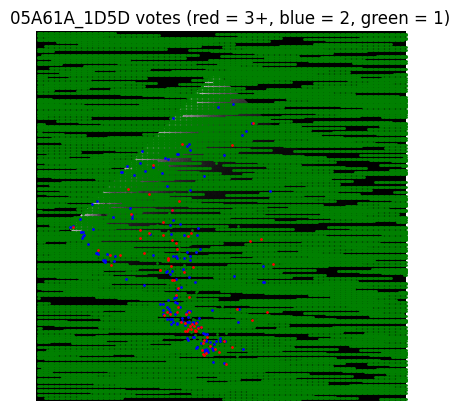

In [15]:
from Utils.plot_votes import plot_votes

plot_votes(votes_coord, image, image_name)

In [11]:
# Output the shapefile with 2 votes, and the shapefile with 3 votes
for i in range(2, 4):
    if i-1 >= len(votes_coord):
        continue
    votes_i = votes_coord[i-1]
    
    Ensemble_out_filename = f"{image_name}_Ensemble_{i}_votes"
    save_shapefile(votes_i, shp_path_maker(image_name, Ensemble_out_filename), gt)